In [65]:
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import plot_model


import matplotlib.pyplot as plt
from json import JSONEncoder
import json

print(tf.version.VERSION)


2.10.0


In [66]:
df = pd.read_csv('customer-cashflow.csv')
df

,monthly_income,spending_behaviour,monthly_expenses,savings_goal,savings_monthly,total_savings_installment
0,27970574.33,wasteful,2.430527e+07,17969923.90,5594114.866,3
1,25341000.18,wasteful,2.488143e+07,6098289.25,5068200.036,1
2,11122799.22,moderate,6.177215e+06,38780432.31,2224559.844,17
3,23551355.09,moderate,1.383332e+07,10346109.22,4710271.018,2
4,5048454.14,frugal,1.571140e+06,12887228.24,1009690.828,13
...,...,...,...,...,...,...
4995,1974699.95,wasteful,1.961812e+06,19609582.62,394939.990,50
4996,28693169.54,moderate,1.495908e+07,14558794.03,5738633.908,3
4997,4640874.05,moderate,2.590697e+06,7671492.41,928174.810,8
4998,3714395.94,wasteful,3.053388e+06,22636089.69,742879.188,30


In [91]:
X = df[['monthly_income','monthly_expenses','savings_goal']].values
Y = df[["savings_monthly","total_savings_installment"]].values


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = tf.keras.layers.Normalization(axis=-1, name="Normalization")
scaler.adapt(x_train)
x_train_scale = scaler(x_train)
x_test_scale = scaler(x_test)

# y_train_scale = scaler_y.fit_transform(y_train)
y1_train = y_train[:,0]
y2_train = y_train[:,1]

# y_test_scale = scaler_y.transform(y_test)
y1_test = y_test[:,0]
y2_test = y_test[:,1]

In [92]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

scaler_weights = scaler.get_weights()
scaler_weights[-1] = np.array([scaler_weights[-1]])
scaler_weights_list = {}
for i, weights in enumerate(scaler_weights):
    scaler_weights_list[i] = weights

with open('save_model/scaler_weights.json', 'w') as json_file:
    json.dump(scaler_weights_list, json_file, cls=NumpyArrayEncoder)

In [93]:
# import pickle

# Save the model using pickle
# with open('save_model/scaler_x.pkl', 'wb') as f:
#     pickle.dump(scaler_x, f)


# Model MLP

In [94]:
def model_mlp(input_shape):
    input_ = Input(shape=input_shape)
    
    x1 = Dense(16, activation='relu', name="dense_saving_1")(input_)
    x1 = Dense(32, activation='relu', name="dense_saving_2")(x1)
    x1 = Dense(64, activation='relu', name="dense_saving_3")(x1)
    x1 = Dense(32, activation='relu', name="dense_saving_4")(x1)
    
    x2 = Dense(16, activation='relu', name="dense_total_1")(input_)
    x2 = Dense(32, activation='relu', name="dense_total_2")(x2)
    x2 = Dense(64, activation='relu', name="dense_total_3")(x2)
    x2 = Dense(32, activation='relu', name="dense_total_4")(x2)
    x2 = Dense(16, activation='relu', name="dense_total_5")(x2)
    y_out1 = Dense(1, activation='linear', name = "saving")(x1)
    y_out2 = Dense(1, activation='linear', name = "total_save")(x2)
    
    model = Model(inputs=input_, outputs=[y_out1, y_out2])
    return model

model = model_mlp((x_train_scale.shape[1]))
model.compile(loss={'saving':'mse', 'total_save':'mse'}, 
              optimizer='adam', 
              metrics = {
                  'saving':tf.keras.metrics.RootMeanSquaredError(),
                  'total_save':tf.keras.metrics.RootMeanSquaredError(),
              })

model.summary()
    

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 dense_total_1 (Dense)          (None, 16)           64          ['input_10[0][0]']               
                                                                                                  
 dense_saving_1 (Dense)         (None, 16)           64          ['input_10[0][0]']               
                                                                                                  
 dense_total_2 (Dense)          (None, 32)           544         ['dense_total_1[0][0]']          
                                                                                            

In [95]:
plot_model(model, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Train model

In [96]:
EPOCHS = 250
history = model.fit(
                x_train_scale, (y1_train, y2_train),
                epochs=EPOCHS, batch_size=8, verbose=1, validation_split=0.2
            )

Epoch 1/250
400/400 [==============================] - 4s 8ms/step - loss: 14572870172672.0000 - saving_loss: 14572870172672.0000 - total_save_loss: 159.9629 - saving_root_mean_squared_error: 3817442.7500 - total_save_root_mean_squared_error: 12.6476 - val_loss: 14289021698048.0000 - val_saving_loss: 14289021698048.0000 - val_total_save_loss: 64.6015 - val_saving_root_mean_squared_error: 3780082.2500 - val_total_save_root_mean_squared_error: 8.0375
Epoch 2/250
400/400 [==============================] - 3s 8ms/step - loss: 7509364965376.0000 - saving_loss: 7509364965376.0000 - total_save_loss: 69.9920 - saving_root_mean_squared_error: 2740322.0000 - total_save_root_mean_squared_error: 8.3661 - val_loss: 1474888728576.0000 - val_saving_loss: 1474888728576.0000 - val_total_save_loss: 45.8678 - val_saving_root_mean_squared_error: 1214450.0000 - val_total_save_root_mean_squared_error: 6.7726
Epoch 3/250
400/400 [==============================] - 3s 7ms/step - loss: 810946920448.0000 - savin

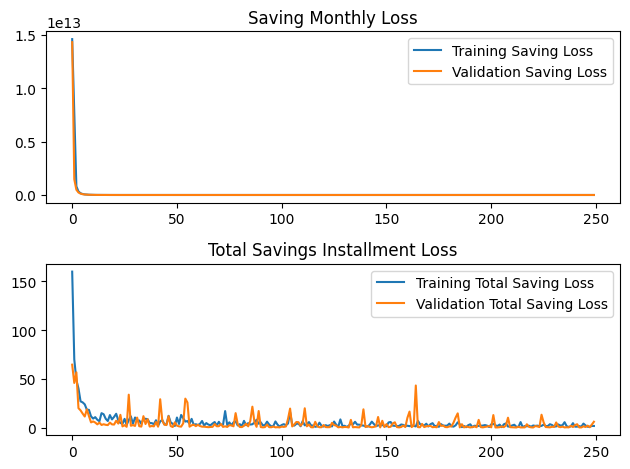

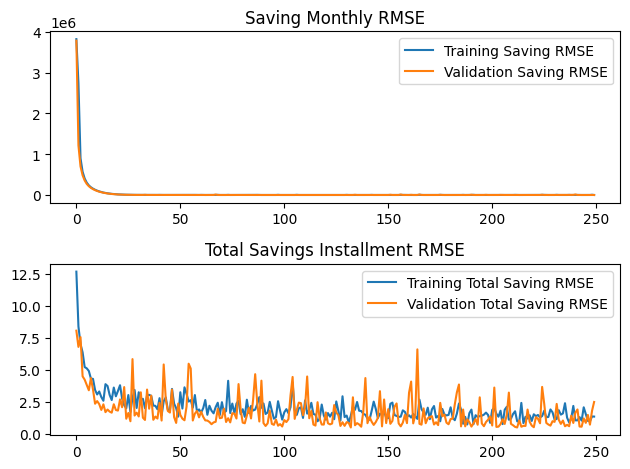

In [97]:
x_axis = np.arange(EPOCHS)
plt.subplot(2,1,1)
plt.plot(x_axis, history.history['saving_loss'], label='Training Saving Loss')
plt.plot(x_axis, history.history['val_saving_loss'], label='Validation Saving Loss')
plt.title("Saving Monthly Loss")
plt.legend()

plt.subplot(2,1,2)
plt.plot(x_axis, history.history['total_save_loss'], label='Training Total Saving Loss')
plt.plot(x_axis, history.history['val_total_save_loss'], label='Validation Total Saving Loss')
plt.title("Total Savings Installment Loss")
plt.legend()

plt.tight_layout()
plt.show()


plt.subplot(2,1,1)
plt.plot(x_axis, history.history['saving_root_mean_squared_error'], label='Training Saving RMSE')
plt.plot(x_axis, history.history['val_saving_root_mean_squared_error'], label='Validation Saving RMSE')
plt.title("Saving Monthly RMSE")
plt.legend()

plt.subplot(2,1,2)
plt.plot(x_axis, history.history['total_save_root_mean_squared_error'], label='Training Total Saving RMSE')
plt.plot(x_axis, history.history['val_total_save_root_mean_squared_error'], label='Validation Total Saving RMSE')
plt.title("Total Savings Installment RMSE")
plt.legend()

plt.tight_layout()
plt.show()

In [98]:
# model.save("save_model/mlp_model.keras")

## Test Model

In [99]:
y_pred1, y_pred2 = model.predict(x_test_scale)

y_pred = np.array([[0.0,0.0]]*len(y_pred1))
for i in range(len(y_pred1)):
    y_pred[i,0] = y_pred1[i,0]
    y_pred[i,1] = round(y_pred2[i,0])
    
y_pred

32/32 [==============================] - 0s 3ms/step


array([[4.72524050e+06, 3.00000000e+00],
       [7.52794000e+06, 1.00000000e+00],
       [1.25052275e+06, 2.70000000e+01],
       ...,
       [4.55965550e+06, 7.00000000e+00],
       [2.60671150e+06, 1.20000000e+01],
       [5.55565550e+06, 3.00000000e+00]])

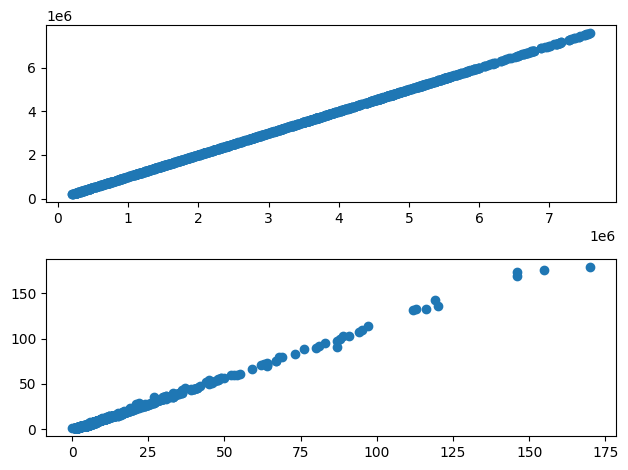

In [100]:
plt.subplot(2,1,1)
plt.scatter(y1_test, y_pred[:,0])

plt.subplot(2,1,2)
plt.scatter(y2_test, y_pred[:,1])

plt.tight_layout()
plt.show()

In [101]:
mse_saving = mean_squared_error(y1_test, y_pred[:,0])
mae_saving = mean_absolute_error(y1_test, y_pred[:,0])

mse_total = mean_squared_error(y2_test, y_pred[:,1])
mae_total = mean_absolute_error(y2_test, y_pred[:,1])

print("Error from savings monthly")
print(f"Mean Squared Error : {mse_saving:.5f}")
print(f"Mean Absolute Error : {mae_saving:.5f}")

print("\nError from total savings installment")
print(f"Mean Squared Error : {mse_total:.5f}")
print(f"Mean Absolute Error : {mae_total:.5f}")

Error from savings monthly
Mean Squared Error : 364.63543
Mean Absolute Error : 5.60273

Error from total savings installment
Mean Squared Error : 9.34500
Mean Absolute Error : 1.29300


In [83]:
mse_saving = mean_squared_error(y1_test, y_pred[:,0])
mae_saving = mean_absolute_error(y1_test, y_pred[:,0])

mse_total = mean_squared_error(y2_test, y_pred[:,1])
mae_total = mean_absolute_error(y2_test, y_pred[:,1])

print("Error from savings monthly")
print(f"Mean Squared Error : {mse_saving:.5f}")
print(f"Mean Absolute Error : {mae_saving:.5f}")

print("\nError from total savings installment")
print(f"Mean Squared Error : {mse_total:.5f}")
print(f"Mean Absolute Error : {mae_total:.5f}")

Error from savings monthly
Mean Squared Error : 875.08709
Mean Absolute Error : 14.94468

Error from total savings installment
Mean Squared Error : 11.75100
Mean Absolute Error : 0.86300


## Save model to JSON

In [102]:
model_json = model.to_json()
with open('save_model/mlp.json', 'w') as json_file:
    json_file.write(model_json)

print("Model architecture saved successfully.")

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

weights_list = model.get_weights()
weights_list_json = {}
for i, weights in enumerate(weights_list):
    weights_list_json[i] = weights

with open('save_model/mlp_weights.json', 'w') as json_file:
    json.dump(weights_list_json, json_file, cls=NumpyArrayEncoder)

Model architecture saved successfully.


## Load from JSON

In [117]:
scaler_weights_list = []
with open('save_model/scaler_weights.json', 'r') as json_file:
    loaded_weights_json = json.load(json_file)
    
    for i in range(len(loaded_weights_json.keys())):
        if i == 2:
            scaler_weights_list.append(loaded_weights_json[str(i)][0])
        else:
            scaler_weights_list.append(np.array(loaded_weights_json[str(i)], dtype=np.float32()))
scaler_weights_list

[array([16833530., 10356300., 21447310.], dtype=float32),
 array([8.8567963e+13, 5.3569168e+13, 1.1273968e+14], dtype=float32),
 4000]

In [105]:
# Load the model architecture from JSON file
with open('save_model/mlp.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
 
 
# Output confirmation message
print("Model architecture loaded successfully.")

        
loaded_weights_list = []
with open('save_model/mlp_weights.json', 'r') as json_file:
    loaded_weights_json = json.load(json_file)
    
    for i in range(len(loaded_weights_json.keys())):
        loaded_weights_list.append(np.array(loaded_weights_json[str(i)]))

Model architecture loaded successfully.


In [106]:
loaded_model.set_weights(loaded_weights_list)

In [107]:
y_pred1_, y_pred2_ = loaded_model.predict(x_test_scale)

y_pred_ = np.array([[0.0,0.0]]*len(y_pred1_))
for i in range(len(y_pred1)):
    y_pred_[i,0] = y_pred1_[i,0]
    y_pred_[i,1] = round(y_pred2_[i,0])
    
y_pred_

32/32 [==============================] - 0s 3ms/step


array([[4.72524050e+06, 3.00000000e+00],
       [7.52794000e+06, 1.00000000e+00],
       [1.25052275e+06, 2.70000000e+01],
       ...,
       [4.55965550e+06, 7.00000000e+00],
       [2.60671150e+06, 1.20000000e+01],
       [5.55565550e+06, 3.00000000e+00]])

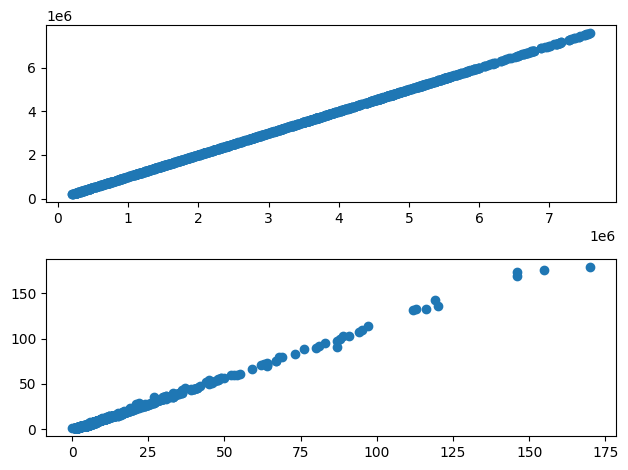

In [108]:
plt.subplot(2,1,1)
plt.scatter(y1_test, y_pred[:,0])

plt.subplot(2,1,2)
plt.scatter(y2_test, y_pred[:,1])

plt.tight_layout()
plt.show()

In [109]:
mse_saving = mean_squared_error(y1_test, y_pred_[:,0])
mae_saving = mean_absolute_error(y1_test, y_pred_[:,0])

mse_total = mean_squared_error(y2_test, y_pred_[:,1])
mae_total = mean_absolute_error(y2_test, y_pred_[:,1])

print("Error from savings monthly")
print(f"Mean Squared Error : {mse_saving:.5f}")
print(f"Mean Absolute Error : {mae_saving:.5f}")

print("\nError from total savings installment")
print(f"Mean Squared Error : {mse_total:.5f}")
print(f"Mean Absolute Error : {mae_total:.5f}")

Error from savings monthly
Mean Squared Error : 364.63543
Mean Absolute Error : 5.60273

Error from total savings installment
Mean Squared Error : 9.34500
Mean Absolute Error : 1.29300
